In [1]:
# Assignment

import numpy as np
from numpy.linalg import inv
from scipy.linalg import toeplitz
import pandas as pd
from tools import export, datafeed
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.precision',2)
sns.set_theme()
plt.rcParams.update({'font.size': 16}) 

# Loading up data
data_name = 'bullionist.csv'

data = datafeed.fetchdata(data_name)
data_mat = datafeed.data_mat(data_name)

In [9]:
data.iloc[100:120,:]

,Industrial Production,CPI
Year,,
1800,5.07,212.0
1801,4.87,228.0
1802,5.14,174.0
1803,5.19,156.0
1804,5.36,161.0
1805,5.48,187.0
1806,5.52,184.0
1807,5.74,186.0
1808,5.46,204.0


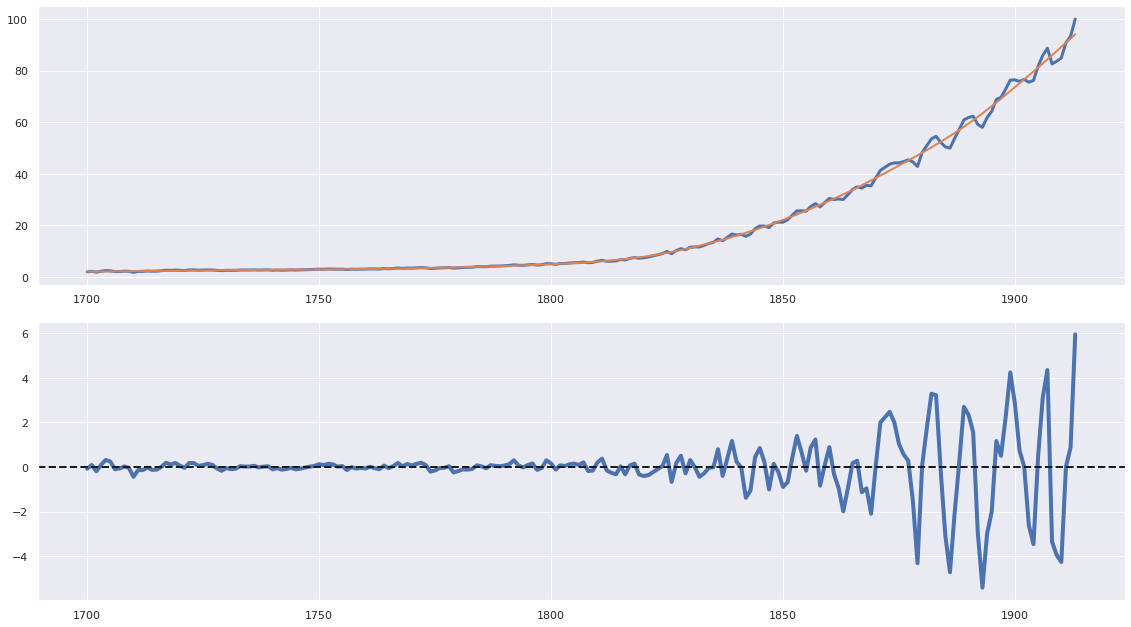

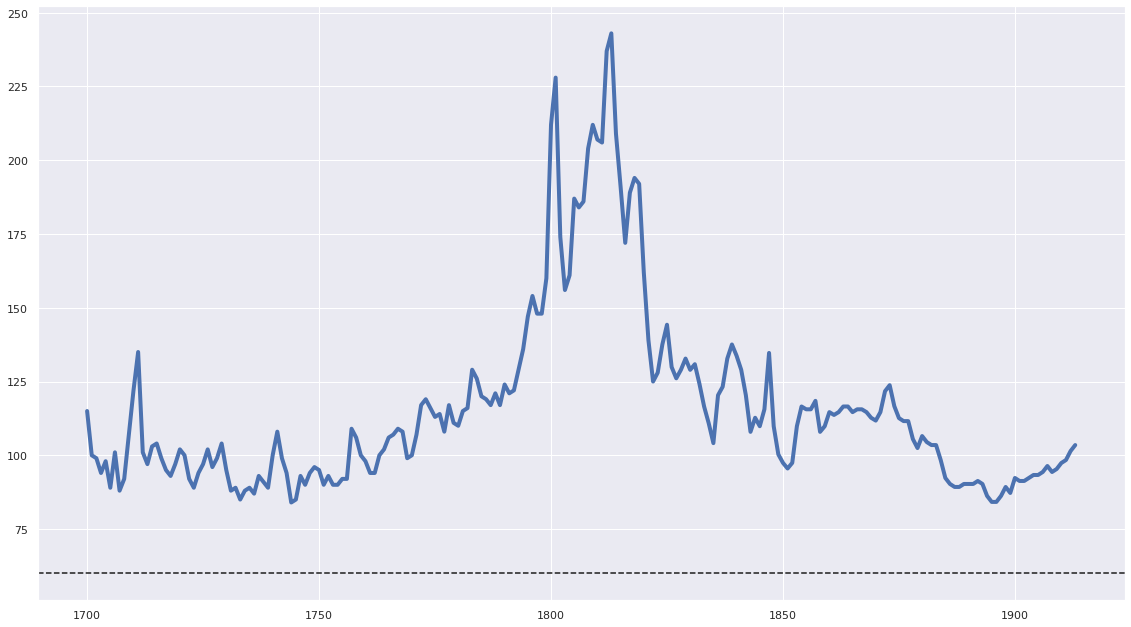

In [2]:
## Descriptive statistics and detrending

data

data.iloc[::12,:]

data.describe()

def HPfilter(data, mu):
    data = np.matrix(data.to_numpy()).T
    N = len(data)
    a = mu
    b = -4*mu
    c = 1+6*mu
    f = [[c,b,a]]
    z = [np.zeros(N-3)]
    d = np.concatenate((f,z),axis=1)
    A = toeplitz(d)
    A[:2,:2] = [[1+mu,-2*mu],[-2*mu,1+5*mu]]
    A[-2:,-2:] = np.rot90(A[:2,:2],2)
    trend = inv(A)*data
    cycle = data - trend
    return trend, cycle

output = data.iloc[:,0]
prices = data.iloc[:,1]

Y_trend, Y_cycle = HPfilter(output,1600)

timeHorizon = np.array(data.index)

fig1, ax = plt.subplots(2,1,figsize=(16,9))
ax[0].plot(timeHorizon,output,lw='3')
ax[0].plot(timeHorizon,Y_trend,lw='2')
ax[1].plot(timeHorizon,Y_cycle,lw='4')
ax[1].axhline(y=0,lw='2',ls='--',c='k')
plt.tight_layout()

fig2, ax = plt.subplots(1,1,figsize=(16,9))
ax.plot(timeHorizon,prices,lw='4')
ax.axhline(y=60,c='k',ls='--')
plt.tight_layout()

In [3]:
## VAR

# Model parameters (INPUTS)
n = np.size(data_mat,0) # No. of variables
N = np.size(data_mat,1) # No. of observations
p = 6 # Order of VAR
const = 1 # Constant (yes/no)
h = 30 # Forecast horizon

# OLS estimation (Y=A*Z+U)
def VAROLS(data,n,N,p,const):
    Y = data[:,p:]
    Z = np.zeros([n*p,N-p])
    for jj in np.arange(N-p):
        Z[:,jj]= np.reshape(np.fliplr(data[:, jj:jj+p]),
                            n*p,order='F')
    Z = np.concatenate((np.ones((const,N-p)),Z),axis=0)
    
    # A=(Y*Y')*inv(Z*Z')
    A = np.dot(np.dot(Y,Z.T),inv(np.dot(Z,Z.T)))
    
    Sigma = (np.dot(Y,Y.T) - np.dot(A, np.dot(Z,Y.T)))/(N-n*p-const)
    return A, Sigma

# VAR(1) representation: Selection (Xi) and companion matrix (J)
def VAR1(A,n,p,const):
    A = A[:, const:]
    
    eye = np.eye(n*(p-1))
    zeros = np.zeros((n*(p-1),n))
    mat = np.concatenate((eye,zeros),axis=1)
    
    Xi = np.concatenate((A,mat),axis=0)
    
    J = np.concatenate((np.eye(n),
                        np.zeros((n,n*(p-1)))),
                       axis=1)
    return Xi, J

# Blanchard-Quach decomposition
def BlanchardQuach(Xi,J,Sigma):
    # Reduced form long-run multiplier
    B1 = np.dot(np.dot(J,np.linalg.inv(np.identity(n*p)-Xi)),J.T)
    # Structural long-run multiplier
    temp = np.dot(np.dot(B1,Sigma),B1.T)
    # Impact matrix
    C1 = np.linalg.cholesky(temp)
    S = np.dot(np.linalg.inv(B1),C1)
    return S, C1

# Matrices needed
A, Sigma = VAROLS(data_mat,n,N,p,const)
Xi, J = VAR1(A,n,p,const)
S, C1 = BlanchardQuach(Xi,J,Sigma)

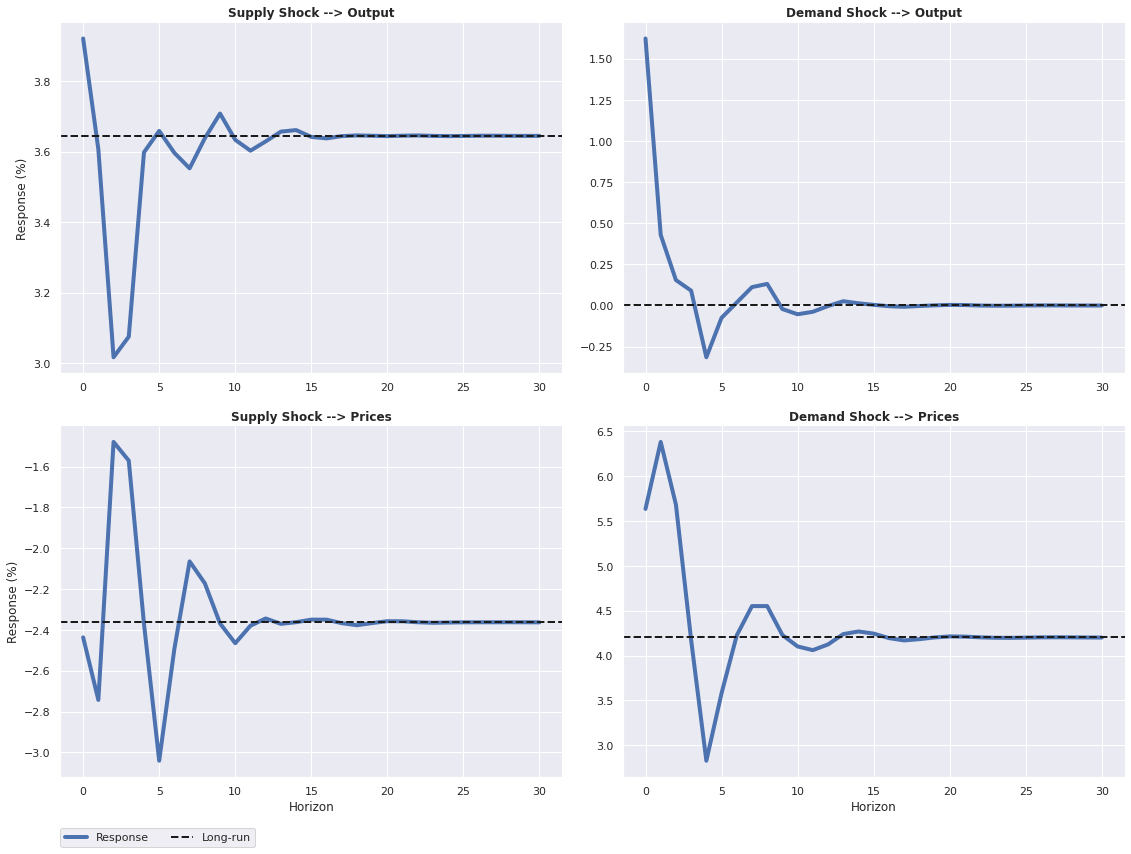

In [4]:
# ---Impulse responses---

epsilon = np.eye(n) # <-- shock matrix. first column: supply shock; second column: demand shock
C = np.zeros((h+1,n,n))

for jj in np.arange(h+1):
    temp1 = np.dot(J, np.linalg.matrix_power(Xi,jj))
    temp2 = np.dot(temp1,J.T)
    temp3 = np.dot(temp2, S)
    C[jj:,:,:] = np.dot(temp3,epsilon)
# ^ this is all in growth rates, not in level (not level responses) we need to add up things

Cs = np.cumsum(C,axis=0) # loop over elements of Cs and take the relevant part of Cs array

# Plots of impulse responses
horizon = np.arange(h+1) # x-axis
shocks = ['Supply Shock','Demand Shock'] # OR = [r'$\mathrm{\epsilon_S}','Demand Error']
response = ['Output','Prices']
#in %
Cs1 = 100*Cs[:,0,0]
Cs2 = 100*Cs[:,0,1]
Cs3 = 100*Cs[:,1,0]
Cs4 = 100*Cs[:,1,1]

fig3, ax = plt.subplots(2,2,figsize=[4*4,3*4])

ax[0,0].plot(horizon,Cs1,lw='4')
ax[0,0].axhline(y=100*C1[0,0],c='k',lw='2',ls='--')
ax[0,1].plot(horizon,Cs2,lw='4')
ax[0,1].axhline(y=100*C1[0,1],c='k',lw='2',ls='--')
ax[1,0].plot(horizon,Cs3,lw='4')
ax[1,0].axhline(y=100*C1[1,0],c='k',lw='2',ls='--')
ax[1,1].plot(horizon,Cs4,lw='4')
ax[1,1].axhline(y=100*C1[1,1],c='k',lw='2',ls='--')

for i in np.arange(2):
    ax[1,i].set_xlabel('Horizon')
    ax[i,0].set_ylabel('Response (%)')
    for j in np.arange(2):
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].set_title(shocks[j] + ' --> ' + response[i]
                          ,fontweight='bold')
ax[1,0].legend(['Response','Long-run'],
               loc='lower left',
               bbox_to_anchor= (0.0, -0.2),
               ncol=2,borderaxespad=0,frameon=True)
plt.tight_layout()

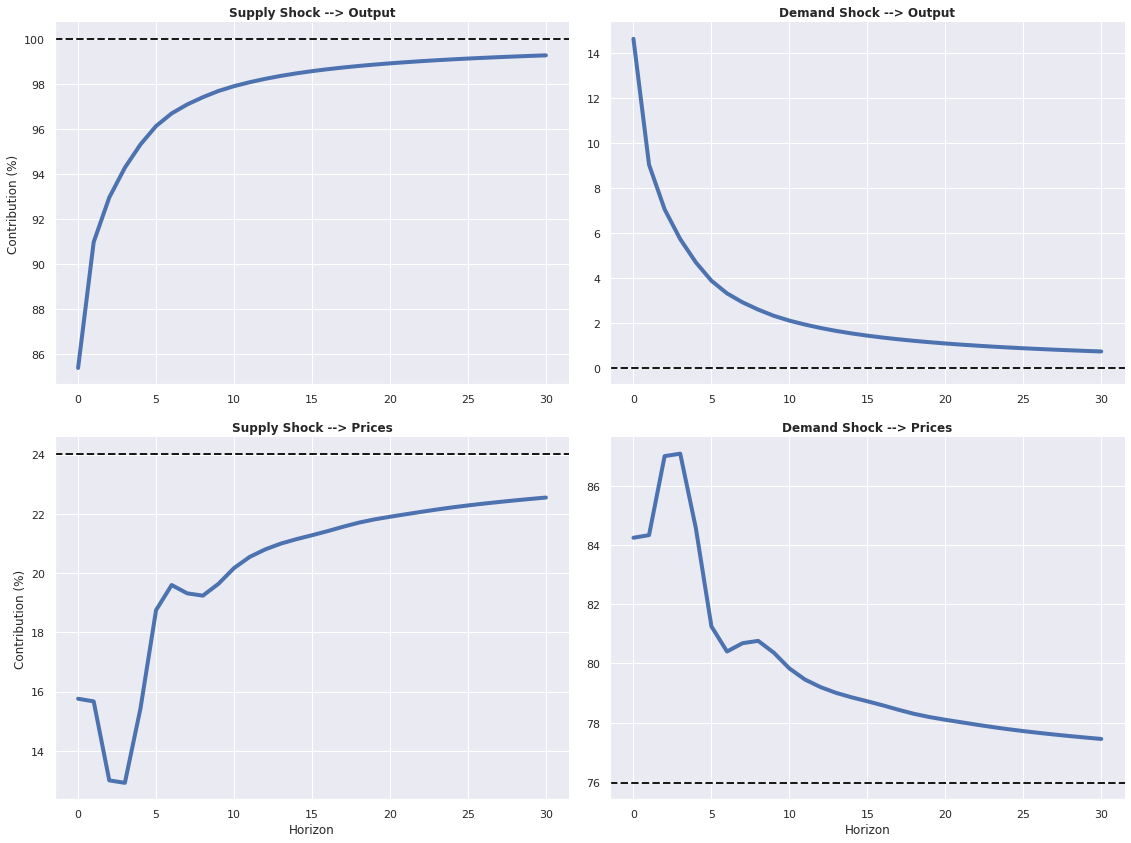

In [5]:
# impulse responses help with identification with AS-AD given the data,
# dont help with the relative importance of demand and supply shock (kind of R^2)

# ---Forcast Error Variance Decomposition---

theta = np.zeros((h+1,n,n))
theta[0,:,:] = (Cs[0,:,:]**2) / np.tile(np.reshape((np.sum(Cs[0,:,:]**2,axis=1)),[n,1]), [1,n])

for jj in np.arange(h):
    # numerator
    theta_numerator = np.sum(Cs[:jj+2,:,:]**2, axis=0)
    # denominator
    d1 = np.transpose(np.sum(Cs[:jj+2,:,:]**2, axis=2))
    d2 = np.transpose(np.array([np.sum(d1, axis=1)]))
    theta_denominator = np.tile(d2, [1,n])
    # final theta
    theta[jj + 1, :, :] = theta_numerator / theta_denominator

# Long-run
theta_long = (C1**2) / np.tile(np.reshape((np.sum(C1**2, axis=1)), [n,1]),[1,n])

# Plots of FEVD
theta1 = 100*theta[:,0,0]
theta2 = 100*theta[:,0,1]
theta3 = 100*theta[:,1,0]
theta4 = 100*theta[:,1,1]

fig4, ax = plt.subplots(2,2,figsize=[4*4,3*4])

ax[0,0].plot(horizon,theta1,lw='4')
ax[0,0].axhline(y=100*theta_long[0,0],c='k',lw='2',ls='--')
ax[0,1].plot(horizon,theta2,lw='4')
ax[0,1].axhline(y=100*theta_long[0,1],c='k',lw='2',ls='--')
ax[1,0].plot(horizon,theta3,lw='4')
ax[1,0].axhline(y=100*theta_long[1,0],c='k',lw='2',ls='--')
ax[1,1].plot(horizon,theta4,lw='4')
ax[1,1].axhline(y=100*theta_long[1,1],c='k',lw='2',ls='--')

for i in np.arange(2):
    ax[1,i].set_xlabel('Horizon')
    ax[i,0].set_ylabel('Contribution (%)')
    for j in np.arange(2):
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].set_title(shocks[j] + ' --> ' + response[i]
                          ,fontweight='bold')
plt.tight_layout()